# Jupyter Notebook for training MLP Model - Tested with Google Colab but should work with any application that runs Jupyter Notebook scripts

In [ ]:
import csv

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
# define file paths - must be changed depending on application to run script
dataset = 'keypoint.csv'
model_path = 'keypoint_classifier/keypoint_classifier.hdf5'
tflite_path = 'keypoint_classifier/keypoint_classifier.tflite'

In [ ]:
# Number of gestures to include in model
NUM_GESTURES = 7

# Read DataSet

In [ ]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [ ]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=42)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32), array([1595, 1663, 1510,  672,  164,  257,  139,  190]))


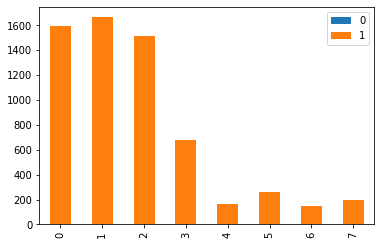

In [ ]:
# count for each gesture
counts = np.unique(y_dataset, return_counts=True)
df = pd.DataFrame(counts)
df.T.plot(kind="bar", stacked=True).set(xlabel = "Gesture ID", ylabel = "# of keypoints")
# print plot
print(counts)

# Build Model with TensorFlow Keras - 3 hidden layers with ReLU, output layer with softmax activation

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )), # 42 keypoints needed for input layer
    tf.keras.layers.Dropout(0.1), # change this value to set dropout rate for each dropout layer
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax') # softmax used for output layer
])

In [ ]:
# output summary of model - method works with Google Colab
model.summary()

Model: "sequential_194"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_582 (Dropout)        (None, 42)                0         
_________________________________________________________________
dense_776 (Dense)            (None, 32)                1376      
_________________________________________________________________
dropout_583 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_777 (Dense)            (None, 32)                1056      
_________________________________________________________________
dropout_584 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_778 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_779 (Dense)            (None, 8)              

In [ ]:
# Model callbacks for checkpoint and early stopping to avoid over training
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_weights_only=False, save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

In [ ]:
# compile model with adam optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [ ]:
# fit model to 100 epochs
model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, earlystopping]
)

In [ ]:
# load the model and recompile to run tests
model = tf.keras.models.load_model(model_path)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Model evaluation - loss and accuracy
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

25/25 [==============================] - 0s 2ms/step - loss: 0.0061 - accuracy: 0.9974


In [ ]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.0000000e+00 8.5401677e-12 1.5222527e-14 7.2429063e-11 3.3295724e-09
 2.5334020e-27 2.3049776e-16 3.3789385e-19]
0


# Classification Report and Confusion Matrix

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    matrix_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_matrix = pd.DataFrame(matrix_data, index=labels, columns=labels)
    # figure for matrix plot, change arguments if using model with different number of gestures
    fig, ax = plt.subplots(figsize=(NUM_GESTURES, 6))
    # create matrix plot with dataframe as a heatmap - optional arguments control color and labels
    sns.heatmap(df_matrix, annot=True, fmt='g' ,square=False, cmap="Blues").set(xlabel = "Predicted Gesture ID", ylabel = "True Gesture ID")
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    # print classification report if successfully generated
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# display the matrix
print_confusion_matrix(y_test, y_pred)

: 

# Save model to Tensorflow-Lite

In [ ]:
# Save as a model dedicated to inference
model.save(model_path, include_optimizer=False)

In [ ]:
# Transform model (quantization) and write to .tflite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpb_379rn7/assets


INFO:tensorflow:Assets written to: /tmp/tmpb_379rn7/assets


7840